In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import snowFun
import dask.array
from shapely.geometry import Point
# %matplotlib widget

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_climate = os.path.join(folder_AGVA, "Climate")

In [2]:
# open rgi attribute table, subsetting to the columns we want
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_df = gpd.read_file(path_rgi, include_fields=["RGIId","CenLon","CenLat","Area","Zmed"])

# path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
# # path_rgi = os.path.join(folder_AGVA, 'RGI', "RGI_v70", "RGI2000-v7.0-G-01_alaska", "RGI2000-v7.0-G-01_alaska-attributes.csv")
# rgi_df = pd.read_csv(path_rgi, usecols=["rgi_id","cenlon","cenlat","area_km2","zmed_m","zmean_m"])
print(rgi_df.shape)
rgi_df.head()

(3031, 6)


,RGIId,CenLon,CenLat,Area,Zmed,geometry
0,RGI60-01.00004,-146.120,63.381,3.681,1944,"POLYGON ((390852.892 1513270.533, 390859.011 1..."
1,RGI60-01.00005,-147.057,63.551,2.573,1914,"POLYGON ((344516.095 1527311.059, 344445.809 1..."
2,RGI60-01.00006,-146.244,63.571,10.470,1740,"POLYGON ((383858.051 1532357.663, 383852.553 1..."
3,RGI60-01.00010,-147.170,63.513,3.806,1666,"POLYGON ((339736.019 1522275.072, 339760.103 1..."
4,RGI60-01.00012,-146.651,63.366,2.802,1725,"POLYGON ((367276.652 1509860.919, 367276.151 1..."


In [9]:
# open the daily temp and precip data
path_t = os.path.join(folder_climate, "era5land_daily_temp_2018_2022.tif")
path_p = os.path.join(folder_climate, "era5land_daily_precip_2018_2022.tif")
path_z = os.path.join(folder_climate, "geo_1279l4_0.1x0.1.grib2_v4_unpack.nc")

t_xr = riox.open_rasterio(path_t).rename({'band':'time'})
p_xr = riox.open_rasterio(path_p).rename({'band':'time'})
t_xr.head()

<xarray.DataArray (time: 5, y: 5, x: 5)>
[125 values with dtype=float64]
Coordinates:
  * time         (time) int32 1 2 3 4 5
  * x            (x) float64 -176.2 -176.1 -176.0 -175.9 -175.8
  * y            (y) float64 63.9 63.8 63.7 63.6 63.5
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

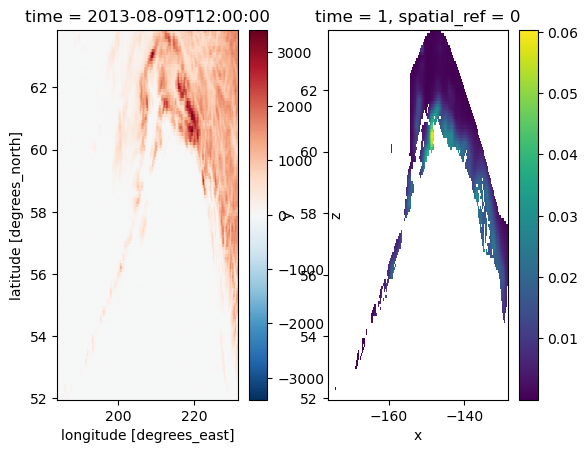

In [10]:
# open geopotential product
z_xr = xr.open_dataset(path_z).z

# convert to geopotential height
z_xr = z_xr/9.80665

# adjust longitude values
# z_xr['longitude'] = z_xr['longitude']-360

# subset to the aoi
z_xr = z_xr.sel( longitude=slice(min(t_xr.x.values)+360, max(t_xr.x.values)+360), latitude=slice(max(t_xr.y.values), min(t_xr.y.values)) )

# resave
z_xr.to_netcdf(path=os.path.join(folder_climate, "orography.nc"))
z_xr.rio.to_raster(raster_path=os.path.join(folder_climate, "orography.tif"))

fig, axs = plt.subplots(1,2)
z_xr.plot(ax=axs[0])
p_xr.sel(time=1).plot(ax=axs[1])

In [5]:
# create list of dates
dates = pd.date_range(start="2018-01-01", end='2022-12-31', freq='D')
print(len(dates), len(t_xr.time))

t_xr['time']=dates
p_xr['time']=dates


1826 1826


In [7]:
# for each rgi (greater than 2km2), extract daily climate data at that lat/lon, save to csv
c=0
n=len(rgi_df)
for idx, row in rgi_df.iterrows():
    c+=1
    if c<325:continue
    print(f"{c} of {n}")
    
        
    rgi_id = row['RGIId']
    cenlon = row['CenLon']
    cenlat = row['CenLat']
    z_med = row["Zmed"]
    
    temps = t_xr.sel(x=cenlon, y=cenlat, method="nearest")
    precips = p_xr.sel(x=cenlon, y=cenlat, method="nearest")
    z = z_xr.sel(longitude=cenlon+360, latitude=cenlat, method='nearest').values[0]
#     print(z)
    
    out_df = pd.DataFrame({'rgi_id':rgi_id,'date':dates,'t':temps,'p':precips, 'z_era5land':z, "zmed_m":z_med})
    out_path = os.path.join(folder_climate, "csv", 'daily', f'{rgi_id}.csv')
    
    out_df.to_csv(out_path, index=False)

325 of 3031
326 of 3031
327 of 3031
328 of 3031
329 of 3031
330 of 3031
331 of 3031
332 of 3031
333 of 3031
334 of 3031
335 of 3031
336 of 3031
337 of 3031
338 of 3031
339 of 3031
340 of 3031
341 of 3031
342 of 3031
343 of 3031
344 of 3031
345 of 3031
346 of 3031
347 of 3031
348 of 3031
349 of 3031
350 of 3031
351 of 3031
352 of 3031
353 of 3031
354 of 3031
355 of 3031
356 of 3031
357 of 3031
358 of 3031
359 of 3031
360 of 3031
361 of 3031
362 of 3031
363 of 3031
364 of 3031
365 of 3031
366 of 3031
367 of 3031
368 of 3031
369 of 3031
370 of 3031
371 of 3031
372 of 3031
373 of 3031
374 of 3031
375 of 3031
376 of 3031
377 of 3031
378 of 3031
379 of 3031
380 of 3031
381 of 3031
382 of 3031
383 of 3031
384 of 3031
385 of 3031
386 of 3031
387 of 3031
388 of 3031
389 of 3031
390 of 3031
391 of 3031
392 of 3031
393 of 3031
394 of 3031
395 of 3031
396 of 3031
397 of 3031
398 of 3031
399 of 3031
400 of 3031
401 of 3031
402 of 3031
403 of 3031
404 of 3031
405 of 3031
406 of 3031
407 of 3031
408 

1008 of 3031
1009 of 3031
1010 of 3031
1011 of 3031
1012 of 3031
1013 of 3031
1014 of 3031
1015 of 3031
1016 of 3031
1017 of 3031
1018 of 3031
1019 of 3031
1020 of 3031
1021 of 3031
1022 of 3031
1023 of 3031
1024 of 3031
1025 of 3031
1026 of 3031
1027 of 3031
1028 of 3031
1029 of 3031
1030 of 3031
1031 of 3031
1032 of 3031
1033 of 3031
1034 of 3031
1035 of 3031
1036 of 3031
1037 of 3031
1038 of 3031
1039 of 3031
1040 of 3031
1041 of 3031
1042 of 3031
1043 of 3031
1044 of 3031
1045 of 3031
1046 of 3031
1047 of 3031
1048 of 3031
1049 of 3031
1050 of 3031
1051 of 3031
1052 of 3031
1053 of 3031
1054 of 3031
1055 of 3031
1056 of 3031
1057 of 3031
1058 of 3031
1059 of 3031
1060 of 3031
1061 of 3031
1062 of 3031
1063 of 3031
1064 of 3031
1065 of 3031
1066 of 3031
1067 of 3031
1068 of 3031
1069 of 3031
1070 of 3031
1071 of 3031
1072 of 3031
1073 of 3031
1074 of 3031
1075 of 3031
1076 of 3031
1077 of 3031
1078 of 3031
1079 of 3031
1080 of 3031
1081 of 3031
1082 of 3031
1083 of 3031
1084 of 3031

1639 of 3031
1640 of 3031
1641 of 3031
1642 of 3031
1643 of 3031
1644 of 3031
1645 of 3031
1646 of 3031
1647 of 3031
1648 of 3031
1649 of 3031
1650 of 3031
1651 of 3031
1652 of 3031
1653 of 3031
1654 of 3031
1655 of 3031
1656 of 3031
1657 of 3031
1658 of 3031
1659 of 3031
1660 of 3031
1661 of 3031
1662 of 3031
1663 of 3031
1664 of 3031
1665 of 3031
1666 of 3031
1667 of 3031
1668 of 3031
1669 of 3031
1670 of 3031
1671 of 3031
1672 of 3031
1673 of 3031
1674 of 3031
1675 of 3031
1676 of 3031
1677 of 3031
1678 of 3031
1679 of 3031
1680 of 3031
1681 of 3031
1682 of 3031
1683 of 3031
1684 of 3031
1685 of 3031
1686 of 3031
1687 of 3031
1688 of 3031
1689 of 3031
1690 of 3031
1691 of 3031
1692 of 3031
1693 of 3031
1694 of 3031
1695 of 3031
1696 of 3031
1697 of 3031
1698 of 3031
1699 of 3031
1700 of 3031
1701 of 3031
1702 of 3031
1703 of 3031
1704 of 3031
1705 of 3031
1706 of 3031
1707 of 3031
1708 of 3031
1709 of 3031
1710 of 3031
1711 of 3031
1712 of 3031
1713 of 3031
1714 of 3031
1715 of 3031

2270 of 3031
2271 of 3031
2272 of 3031
2273 of 3031
2274 of 3031
2275 of 3031
2276 of 3031
2277 of 3031
2278 of 3031
2279 of 3031
2280 of 3031
2281 of 3031
2282 of 3031
2283 of 3031
2284 of 3031
2285 of 3031
2286 of 3031
2287 of 3031
2288 of 3031
2289 of 3031
2290 of 3031
2291 of 3031
2292 of 3031
2293 of 3031
2294 of 3031
2295 of 3031
2296 of 3031
2297 of 3031
2298 of 3031
2299 of 3031
2300 of 3031
2301 of 3031
2302 of 3031
2303 of 3031
2304 of 3031
2305 of 3031
2306 of 3031
2307 of 3031
2308 of 3031
2309 of 3031
2310 of 3031
2311 of 3031
2312 of 3031
2313 of 3031
2314 of 3031
2315 of 3031
2316 of 3031
2317 of 3031
2318 of 3031
2319 of 3031
2320 of 3031
2321 of 3031
2322 of 3031
2323 of 3031
2324 of 3031
2325 of 3031
2326 of 3031
2327 of 3031
2328 of 3031
2329 of 3031
2330 of 3031
2331 of 3031
2332 of 3031
2333 of 3031
2334 of 3031
2335 of 3031
2336 of 3031
2337 of 3031
2338 of 3031
2339 of 3031
2340 of 3031
2341 of 3031
2342 of 3031
2343 of 3031
2344 of 3031
2345 of 3031
2346 of 3031

2901 of 3031
2902 of 3031
2903 of 3031
2904 of 3031
2905 of 3031
2906 of 3031
2907 of 3031
2908 of 3031
2909 of 3031
2910 of 3031
2911 of 3031
2912 of 3031
2913 of 3031
2914 of 3031
2915 of 3031
2916 of 3031
2917 of 3031
2918 of 3031
2919 of 3031
2920 of 3031
2921 of 3031
2922 of 3031
2923 of 3031
2924 of 3031
2925 of 3031
2926 of 3031
2927 of 3031
2928 of 3031
2929 of 3031
2930 of 3031
2931 of 3031
2932 of 3031
2933 of 3031
2934 of 3031
2935 of 3031
2936 of 3031
2937 of 3031
2938 of 3031
2939 of 3031
2940 of 3031
2941 of 3031
2942 of 3031
2943 of 3031
2944 of 3031
2945 of 3031
2946 of 3031
2947 of 3031
2948 of 3031
2949 of 3031
2950 of 3031
2951 of 3031
2952 of 3031
2953 of 3031
2954 of 3031
2955 of 3031
2956 of 3031
2957 of 3031
2958 of 3031
2959 of 3031
2960 of 3031
2961 of 3031
2962 of 3031
2963 of 3031
2964 of 3031
2965 of 3031
2966 of 3031
2967 of 3031
2968 of 3031
2969 of 3031
2970 of 3031
2971 of 3031
2972 of 3031
2973 of 3031
2974 of 3031
2975 of 3031
2976 of 3031
2977 of 3031